#### 1. 필요한 라이브러리 import 및 데이터 불러오기

In [583]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings  # 경고 메시지 무시
warnings.filterwarnings('ignore')

# 한글 폰트를 설정하여 시각화에 한글이 깨지지 않도록 설정
plt.rcParams['font.family'] = 'gulim'

In [584]:
file = pd.read_csv("C:/Users/Owner/Desktop/kdramalist.csv")
file.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,NaN,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,NaN,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


In [585]:
data= pd.DataFrame(file)
data.head()
target = data['charges']

In [586]:
data.shape

(1000000, 12)

In [587]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   age                     1000000 non-null  int64  
 1   gender                  1000000 non-null  object 
 2   bmi                     1000000 non-null  float64
 3   children                1000000 non-null  int64  
 4   smoker                  1000000 non-null  object 
 5   region                  1000000 non-null  object 
 6   medical_history         749238 non-null   object 
 7   family_medical_history  749596 non-null   object 
 8   exercise_frequency      1000000 non-null  object 
 9   occupation              1000000 non-null  object 
 10  coverage_level          1000000 non-null  object 
 11  charges                 1000000 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 91.6+ MB


In [588]:
data.describe()

,age,bmi,children,charges
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,41.495282,34.001839,2.499886,16735.117481
std,13.855189,9.231680,1.707679,4415.808211
min,18.000000,18.000000,0.000000,3445.011643
25%,29.000000,26.020000,1.000000,13600.372379
50%,41.000000,34.000000,2.000000,16622.127973
75%,53.000000,41.990000,4.000000,19781.465410
max,65.000000,50.000000,5.000000,32561.560374


#### 2.결측치 처리 및 데이터 타입 변경

In [589]:
data.isnull().sum()

age                            0
gender                         0
bmi                            0
children                       0
smoker                         0
region                         0
medical_history           250762
family_medical_history    250404
exercise_frequency             0
occupation                     0
coverage_level                 0
charges                        0
dtype: int64

In [590]:
## 결측치는 아예 제거 하기로 하고 결측치가 제거된 데이터를 df변수에 담는다.
df = data.dropna()

In [591]:
## 결측치가 잘 제거됐는지 확인
df.isnull().sum()

age                       0
gender                    0
bmi                       0
children                  0
smoker                    0
region                    0
medical_history           0
family_medical_history    0
exercise_frequency        0
occupation                0
coverage_level            0
charges                   0
dtype: int64

In [592]:
## 문자형 변수는 추후 모델 성능을 위해 범주형 변수로 변환.
def convert_to_categorical(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category')
    
    return df
## 처리과정에서의 에러를 방지하기 위해 수치형 변수는 모두 float64로 변환.
def convert_to_float(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('float64')

    return df
df = convert_to_categorical(df)
df = convert_to_float(df)

In [593]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 561672 entries, 1 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   age                     561672 non-null  float64 
 1   gender                  561672 non-null  category
 2   bmi                     561672 non-null  float64 
 3   children                561672 non-null  float64 
 4   smoker                  561672 non-null  category
 5   region                  561672 non-null  category
 6   medical_history         561672 non-null  category
 7   family_medical_history  561672 non-null  category
 8   exercise_frequency      561672 non-null  category
 9   occupation              561672 non-null  category
 10  coverage_level          561672 non-null  category
 11  charges                 561672 non-null  float64 
dtypes: category(8), float64(4)
memory usage: 25.7 MB


#### 3.칼럼별 통계정보 확인

In [594]:
age = df[['age']]
age.describe()

,age
count,561672.000000
mean,41.492821
std,13.857684
min,18.000000
25%,29.000000
50%,41.000000
75%,53.000000
max,65.000000


In [595]:
gender = df['gender']
gender.value_counts()

gender
male      281056
female    280616
Name: count, dtype: int64

In [596]:
bmi = df['bmi']
bmi.describe()

count    561672.000000
mean         33.989205
std           9.235109
min          18.000000
25%          26.010000
50%          33.960000
75%          41.990000
max          50.000000
Name: bmi, dtype: float64

In [597]:
children = df['children']
children.describe()

count    561672.000000
mean          2.498723
std           1.708084
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           5.000000
Name: children, dtype: float64

In [598]:
smoker = df['smoker']
smoker.value_counts()

smoker
yes    280993
no     280679
Name: count, dtype: int64

In [599]:
region = df['region']
region.value_counts()

region
northeast    140835
southwest    140469
southeast    140409
northwest    139959
Name: count, dtype: int64

In [600]:
medical_history = df['medical_history']
medical_history.value_counts()

medical_history
Heart disease          187846
Diabetes               186957
High blood pressure    186869
Name: count, dtype: int64

In [601]:
family_medical_history = df['family_medical_history']
family_medical_history.value_counts()

family_medical_history
Heart disease          187302
Diabetes               187224
High blood pressure    187146
Name: count, dtype: int64

In [602]:
exercise_frequency = df['exercise_frequency']
exercise_frequency.value_counts()

exercise_frequency
Occasionally    140615
Rarely          140567
Never           140285
Frequently      140205
Name: count, dtype: int64

In [603]:
occupation = df['occupation']
occupation.value_counts()

occupation
Unemployed      140880
Student         140626
Blue collar     140330
White collar    139836
Name: count, dtype: int64

In [604]:
coverage_level = df['coverage_level']
coverage_level.value_counts()

coverage_level
Standard    187704
Basic       187043
Premium     186925
Name: count, dtype: int64

In [605]:
medical_history = df['medical_history']
medical_history.value_counts()

medical_history
Heart disease          187846
Diabetes               186957
High blood pressure    186869
Name: count, dtype: int64

#### 3-1. 이상치 확인

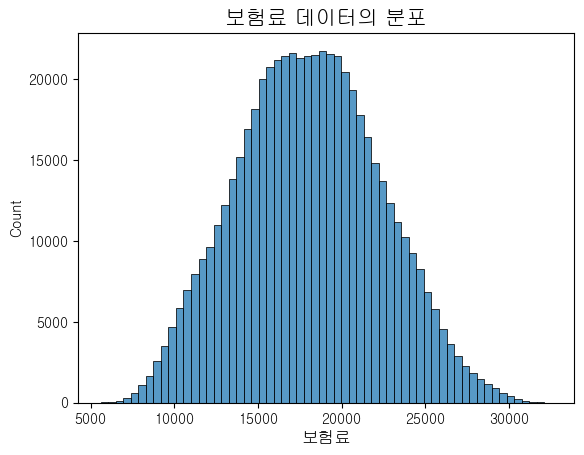

In [606]:
fig = sns.histplot(data=df, x='charges', bins=60)
plt.xlabel("보험료",fontsize=12)
plt.title("보험료 데이터의 분포",fontsize=15)
plt.show()

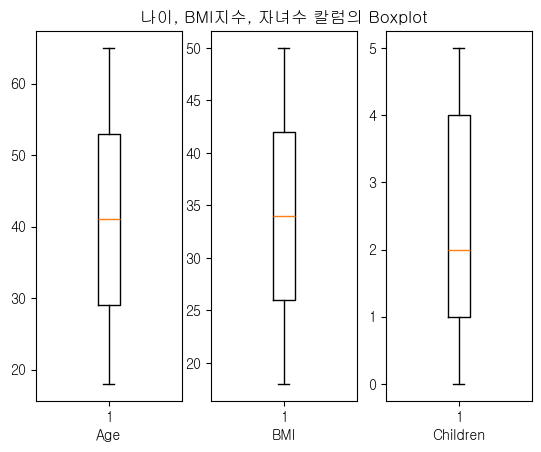

In [607]:
boxplot = plt.figure()

axes1 = boxplot.add_subplot(1, 3, 1)
axes1.boxplot(x = df['age'])
plt.xlabel('Age')


axes2 = boxplot.add_subplot(1, 3, 2)
axes2.boxplot(x = df['bmi'])
plt.xlabel('BMI')
plt.title("나이, BMI지수, 자녀수 칼럼의 Boxplot")

axes3 = boxplot.add_subplot(1, 3, 3)
axes3.boxplot(x= df['children'])
plt.xlabel('Children')


plt.show()


> 위 그래프를 통해 Age, BMI, Children 칼럼 모두 이상치 없음을 확인.  
Age : 데이터의 분포는 약 20에서 60 사이로 나타남. 중앙값은 약 40세.  
BMI : 데이터의 분포는 약 20에서 50사이로 나타남. 중앙값은 약 34로 보임.  
Children : 데이터의 분포는 0에서 5로 나타남. 중앙값은 2.  


#### 4. 모델 학습에 필요없는 변수 제거

<Axes: xlabel='연령대'>

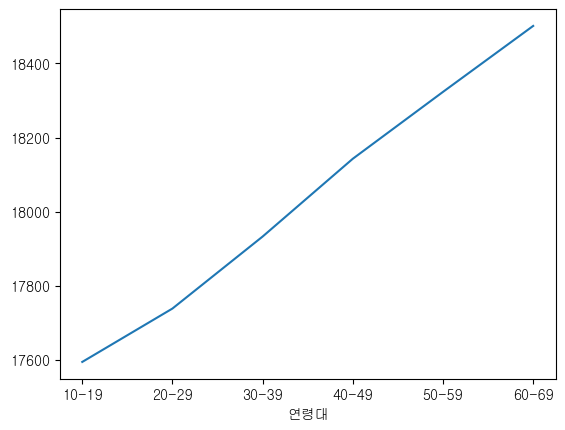

In [608]:
## age와 charges
df01 = df.copy()
df01["연령대"] = pd.cut(x = df['age'], bins = [0, 10, 20, 30, 40, 50, 60, 70, 80],
                           labels = ["0-9","10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70+"], right = False)
df01.groupby(['연령대'])['charges'].mean().plot.line()

<Axes: xlabel='gender'>

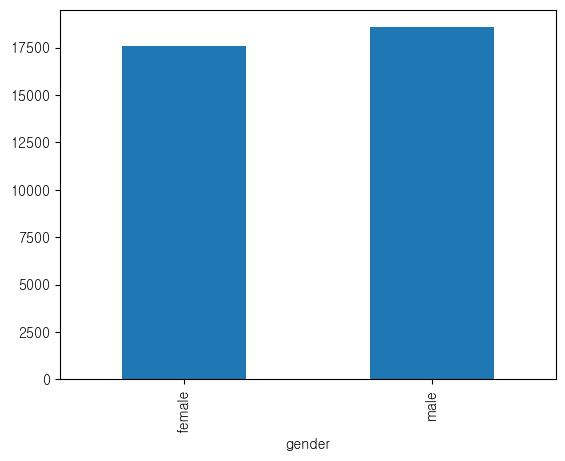

In [609]:
df.groupby(['gender'])['charges'].mean().plot.bar()

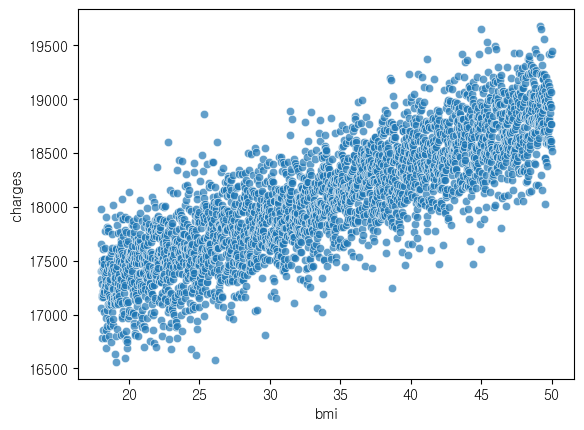

In [610]:
bmi_charges_mean = df.groupby(['bmi'])['charges'].mean().reset_index()

sns.scatterplot(data=bmi_charges_mean, x='bmi', y='charges', alpha= 0.7)
plt.show()

<Axes: xlabel='smoker'>

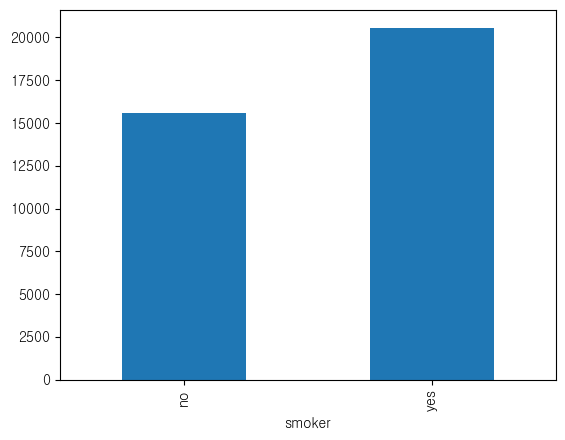

In [611]:
df.groupby(['smoker'])['charges'].mean().plot.bar()

<Axes: xlabel='region'>

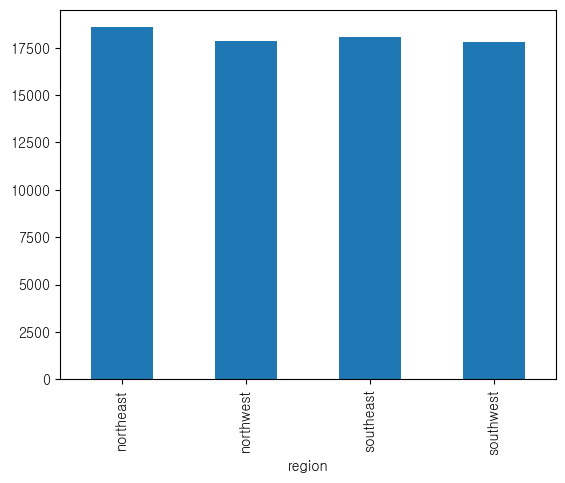

In [612]:
df.groupby(['region'])['charges'].mean().plot.bar()


<Axes: xlabel='medical_history'>

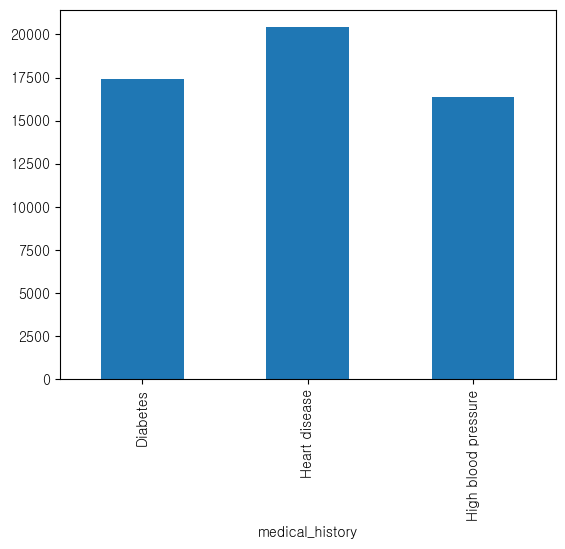

In [613]:
df.groupby(['medical_history'])['charges'].mean().plot.bar()

<Axes: xlabel='family_medical_history'>

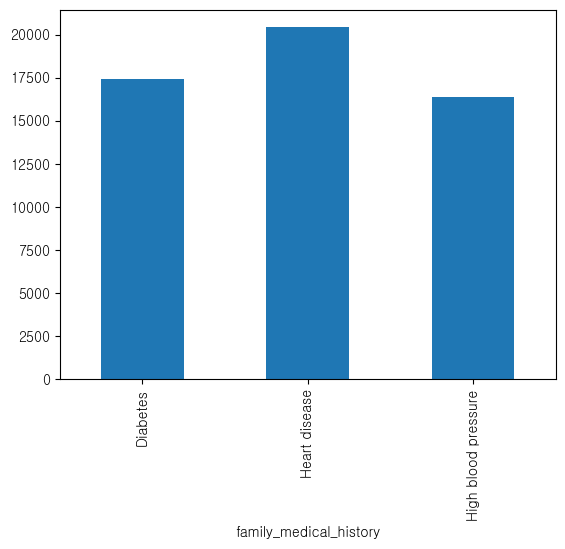

In [614]:
df.groupby(['family_medical_history'])['charges'].mean().plot.bar()

<Axes: xlabel='exercise_frequency'>

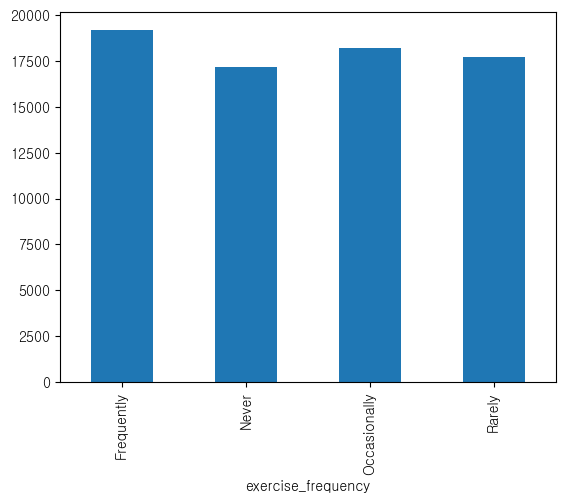

In [615]:
df.groupby(['exercise_frequency'])['charges'].mean().plot.bar()

<Axes: xlabel='occupation'>

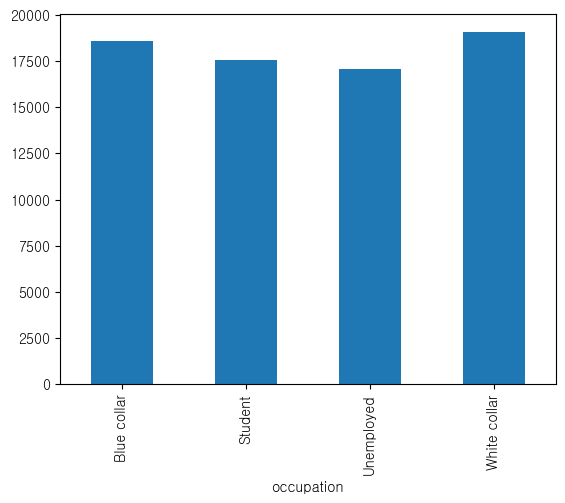

In [616]:
df.groupby(['occupation'])['charges'].mean().plot.bar()

<Axes: xlabel='coverage_level'>

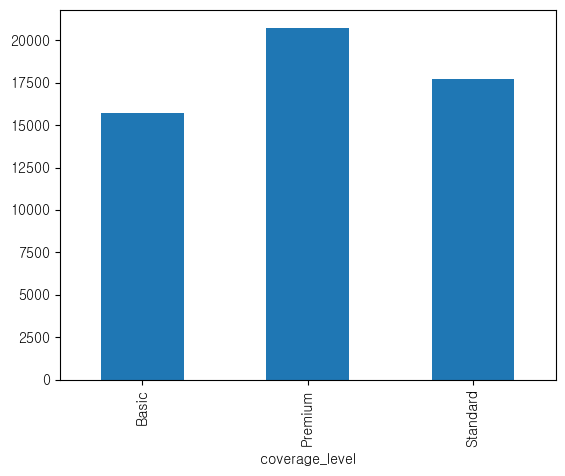

In [617]:
df.groupby(['coverage_level'])['charges'].mean().plot.bar()

> 위 그래프로   
연령이 높은 경우,  bmi지수가 높은 경우, 흡연자인 경우, 심장병이 있는 경우,   운동을 자주 하는 경우, 보험 적용 범위가 넓은 경우에 보험료가 높아지는 것을 확인할 수 있다.   
그래프로 확인했을 때 지역, 성별, 직업에 따른 보험료의 변화는 위에 제시한 경우보단 미미하다고 판단하여 해당 칼럼들은 모델 학습시 제거하기로 한다.


In [618]:
df = df.drop(columns=['region', 'gender', 'occupation'])
### 변수 제거됐는지 확인
df.columns

Index(['age', 'bmi', 'children', 'smoker', 'medical_history',
       'family_medical_history', 'exercise_frequency', 'coverage_level',
       'charges'],
      dtype='object')

#### 5. 범주형 변수 인코딩 

In [619]:
ct = make_column_transformer(
    (OneHotEncoder(sparse_output=False),['smoker', 'medical_history', 'family_medical_history', 'exercise_frequency', 'coverage_level']), 
    remainder='passthrough')
df = ct.fit_transform(df)
df = pd.DataFrame(df, columns=ct.get_feature_names_out())
df.head()

,onehotencoder__smoker_no,onehotencoder__smoker_yes,onehotencoder__medical_history_Diabetes,onehotencoder__medical_history_Heart disease,onehotencoder__medical_history_High blood pressure,onehotencoder__family_medical_history_Diabetes,onehotencoder__family_medical_history_Heart disease,onehotencoder__family_medical_history_High blood pressure,onehotencoder__exercise_frequency_Frequently,onehotencoder__exercise_frequency_Never,onehotencoder__exercise_frequency_Occasionally,onehotencoder__exercise_frequency_Rarely,onehotencoder__coverage_level_Basic,onehotencoder__coverage_level_Premium,onehotencoder__coverage_level_Standard,remainder__age,remainder__bmi,remainder__children,remainder__charges
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,25.0,25.38,2.0,20390.899218
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,49.0,38.21,3.0,19268.309838
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,64.0,20.12,2.0,9563.655011
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,53.0,30.51,4.0,15845.293730
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,45.0,39.68,1.0,14892.145930


#### 6. 상관관계 분석

In [620]:
correlations = df.corrwith(df['remainder__charges'])
(correlations).sort_values(ascending=False)

remainder__charges                                           1.000000
onehotencoder__smoker_yes                                    0.585736
onehotencoder__coverage_level_Premium                        0.441602
onehotencoder__family_medical_history_Heart disease          0.387086
onehotencoder__medical_history_Heart disease                 0.385946
onehotencoder__exercise_frequency_Frequently                 0.150534
remainder__bmi                                               0.109080
remainder__children                                          0.080084
remainder__age                                               0.064939
onehotencoder__exercise_frequency_Occasionally               0.019897
onehotencoder__exercise_frequency_Rarely                    -0.051462
onehotencoder__coverage_level_Standard                      -0.054452
onehotencoder__medical_history_Diabetes                     -0.109496
onehotencoder__family_medical_history_Diabetes              -0.110649
onehotencoder__exerc

> 흡연자인 경우, 보험 적용 범위가 넓은 경우, 가족력에 심장병이 있거나 심장병 이력이 있는 경우에 보험료와 상관관계가 높다. 

<Axes: >

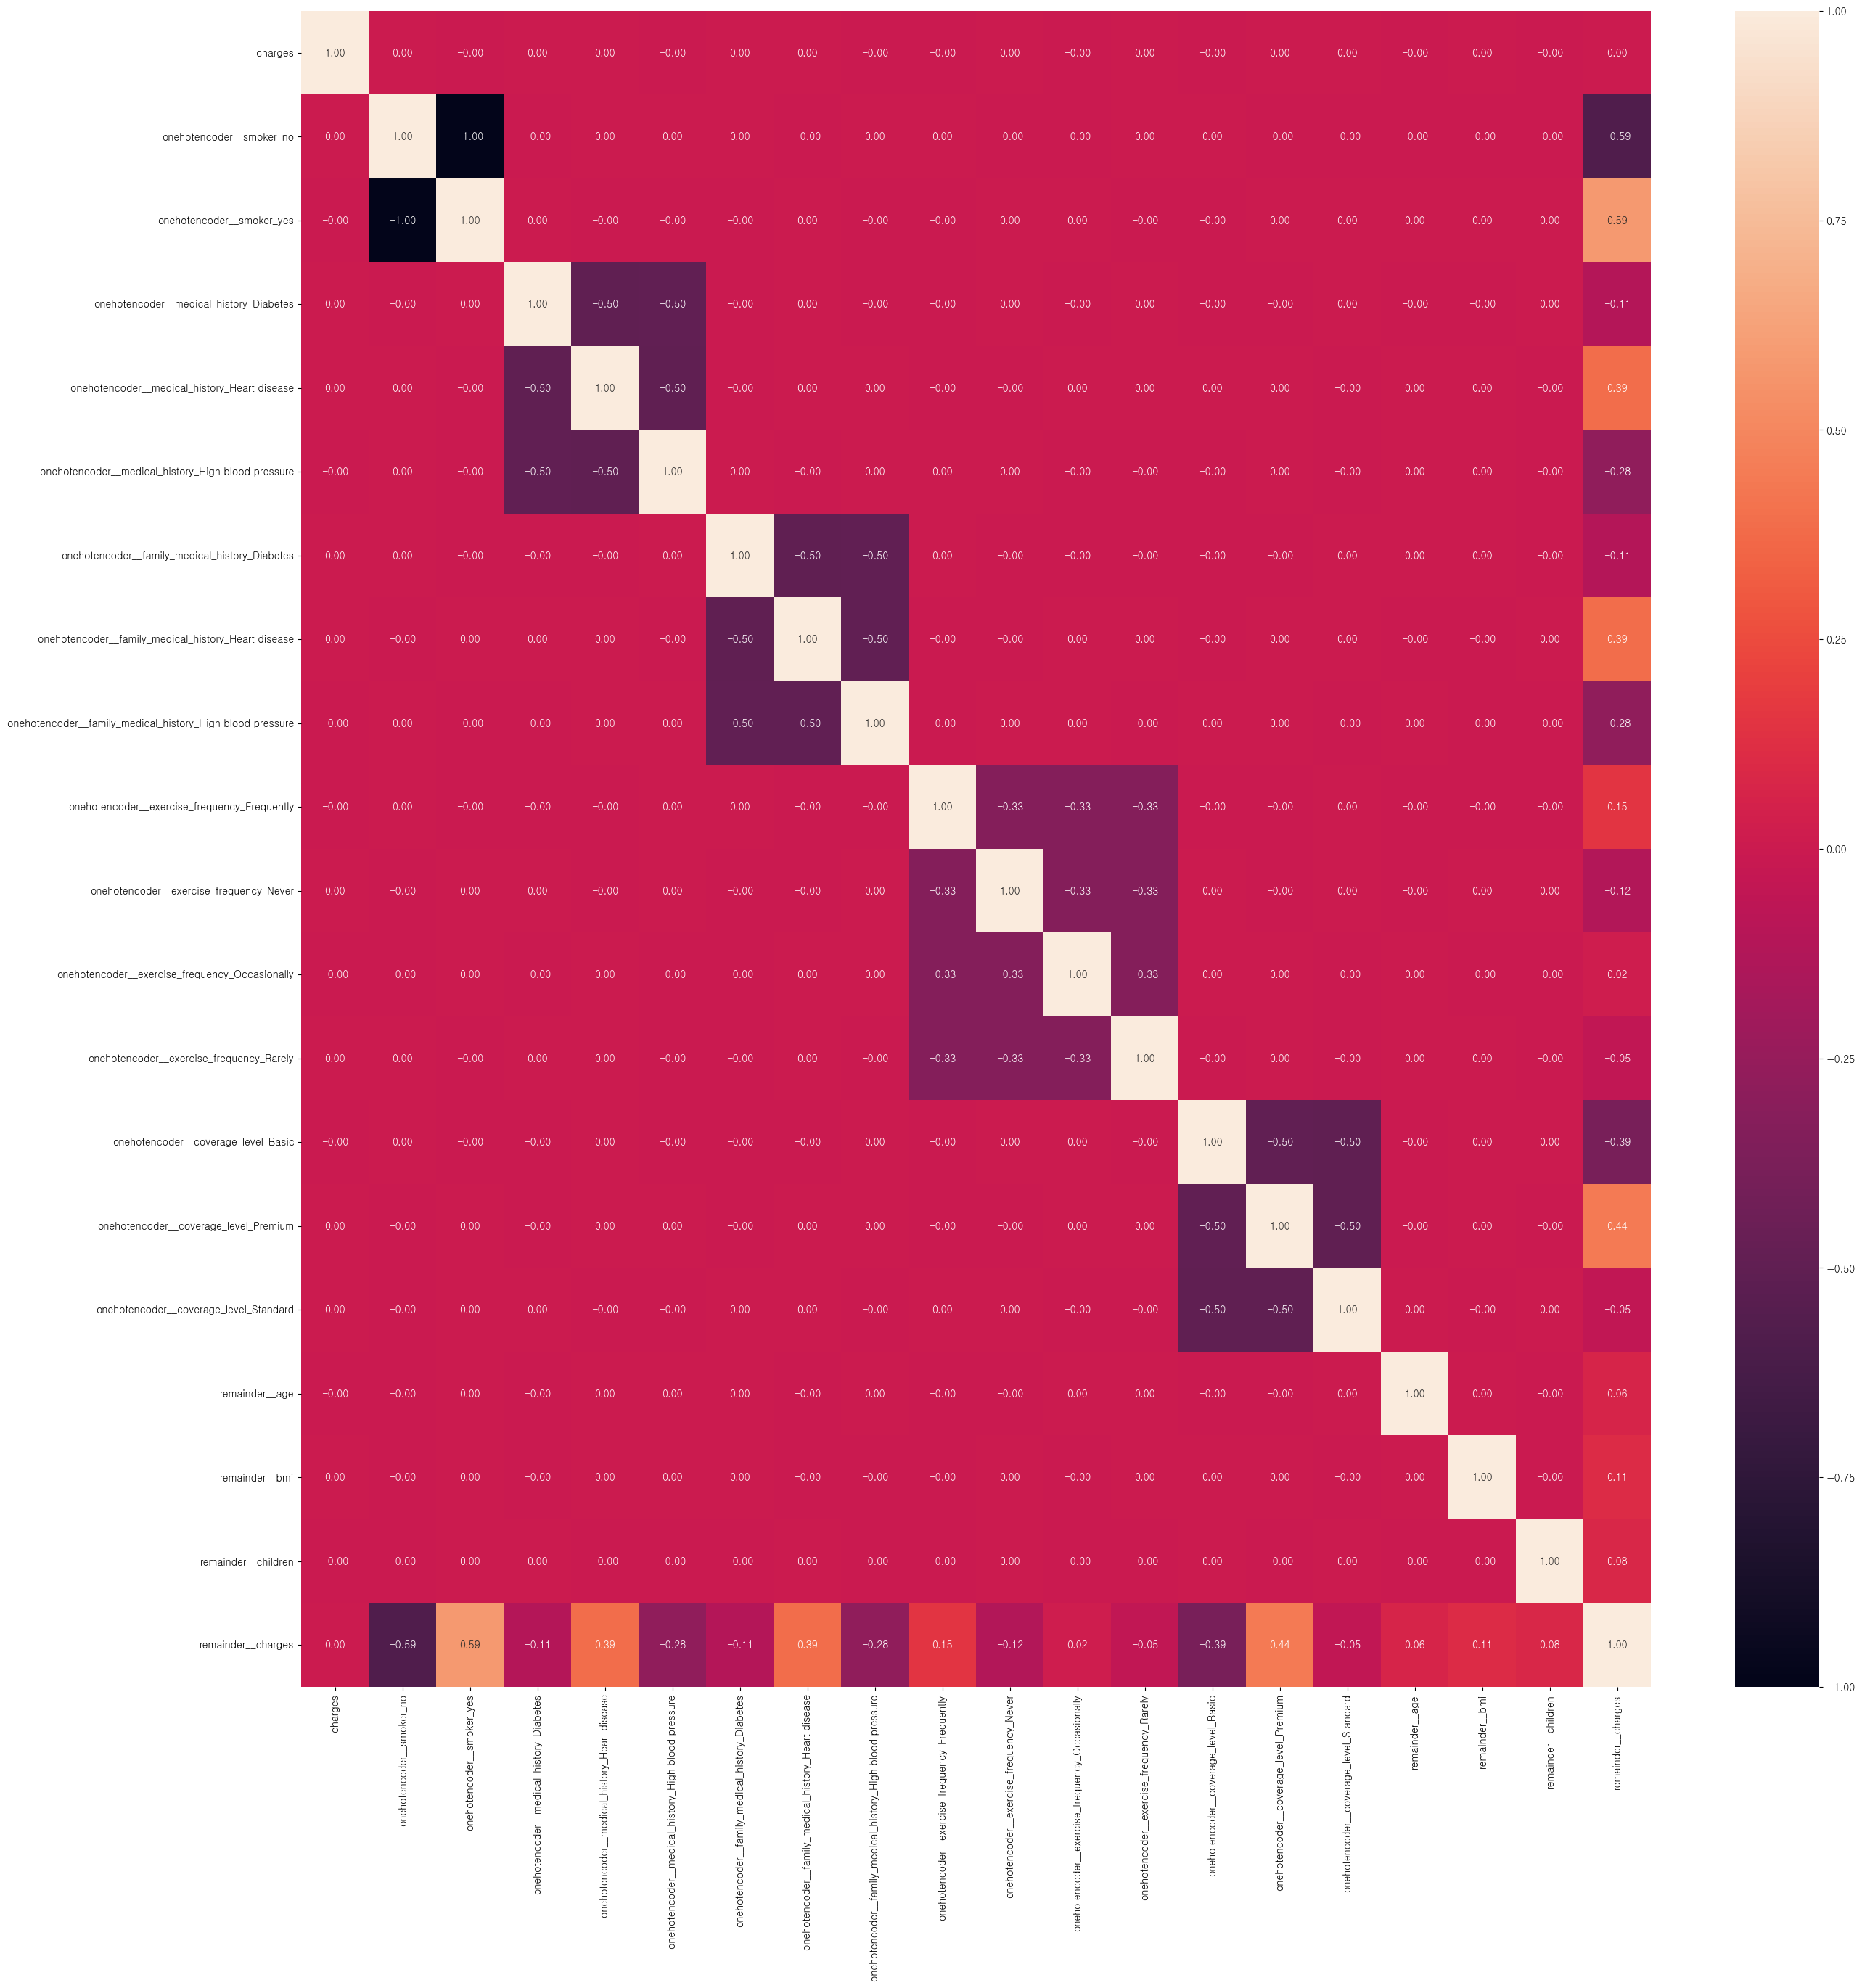

In [621]:
correlation_matrix = pd.concat((target, df), axis=1).corr()

plt.figure(figsize = (30,30))
sns.heatmap(correlation_matrix,vmax=1, vmin=-1, annot=True, fmt=".2f")

> 그래프 가장 아래쪽을 보면 알 수 있듯이,   
흡연자인 경우 0.59, 보험 플랜이 프리미엄인 경우 0.44, 가족력에 심장병이 있거나 심장병 이력이 있는 경우 0.33의 높은 상관관계를 보인다. 

ConversionError: Failed to convert value(s) to axis units: '0.0 = 비흡연, 1.0 = 흡연'

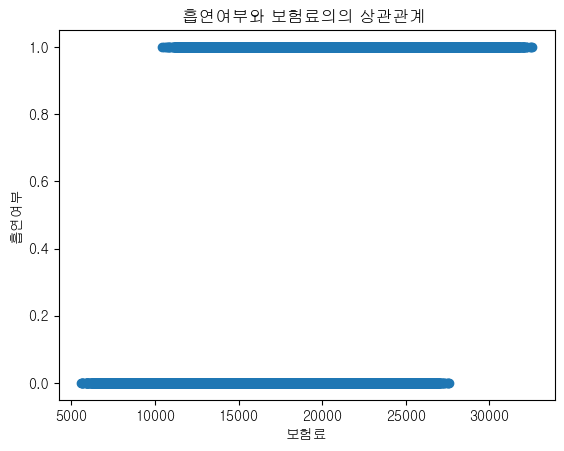

In [630]:
## 흡연여부와 보험료의 상관관계

plt.scatter( x = df['remainder__charges'], y = df['onehotencoder__smoker_yes'])
plt.title("흡연여부와 보험료의의 상관관계 ")
plt.xlabel("보험료")
plt.ylabel("흡연여부")  
plt.yticks("0.0 = 비흡연, 1.0 = 흡연")
plt.show()

성으나 내가 위에다가 charge랑 상관관계가 가장 높은 거 간단하게 분석해놨거든??  여기 밑에다가 너가 말한 가족력과 질병 이력 상관관계 추가로 분석하면 될 것 같애. 일단 지금 내 머리에서 나오는 건 여기까지야.,,,, 아침에 봐용용

In [622]:
### 성으나 아니면 아예 이 가족력에 따른 
## data['family_medical_history'] == data['medical_history']
matching_rows = df[df['family_medical_history'] == df['medical_history']]
matching_count = len(matching_rows)
print("일치하는 행의 개수:", matching_count)

KeyError: 'family_medical_history'

In [ ]:
##'exercise_frequency' 열로 그룹화하고 'bmi' 열을 분류

##이거는 필요할까??? 예측하고자 하는 게 charge인데 운동빈도에 따른 bmi지수 분석으로 빠지면 코드가 더 길어질 것 같다는 개인적인 생각이얌..
bmi_counts= df.groupby('exercise_frequency')['bmi'].value_counts()

# 결과 출력
print(bmi_counts)

KeyError: 'exercise_frequency'

In [49]:
##  bmi >= 25 그리고 medical_history == 'High blood pressure'
filtered_data = data[(data['bmi'] >= 25) & (data['medical_history'] == 'High blood pressure')]
filtered_columns1 = filtered_data[['bmi', 'medical_history']]

print(filtered_columns1)

count = len(filtered_columns1)

# 결과 출력
print(f"조건: bmi >= 25 그리고 medical_history == 'High blood pressure': {count}")

          bmi      medical_history
11      39.68  High blood pressure
13      39.95  High blood pressure
22      31.11  High blood pressure
28      26.46  High blood pressure
29      30.75  High blood pressure
...       ...                  ...
999977  32.26  High blood pressure
999985  37.00  High blood pressure
999991  32.51  High blood pressure
999992  25.92  High blood pressure
999998  45.06  High blood pressure

[146046 rows x 2 columns]
조건: bmi >= 25 그리고 medical_history == 'High blood pressure': 146046


In [50]:
## bmi >= 25 그리고 medical_history == 'Heart disease'
filtered_data = data[(data['bmi'] >= 25) & (data['medical_history'] == 'Heart disease')]
filtered_columns2 = filtered_data[['bmi', 'medical_history']]

print(filtered_columns2)

count = len(filtered_columns2)

# 결과 출력
print(f"조건: bmi >= 25 그리고 medical_history == 'Heart disease': {count}")

          bmi medical_history
7       30.51   Heart disease
26      39.70   Heart disease
30      41.15   Heart disease
46      38.53   Heart disease
49      40.31   Heart disease
...       ...             ...
999957  45.03   Heart disease
999958  34.19   Heart disease
999960  26.38   Heart disease
999978  40.60   Heart disease
999997  39.84   Heart disease

[146856 rows x 2 columns]
조건: bmi >= 25 그리고 medical_history == 'Heart disease': 146856


In [51]:
## 'exercise_frequency' 열로 그룹화하고 'medical_history' 열을 분류
exercisemedicalhistory_counts= data.groupby('exercise_frequency')['medical_history'].value_counts()

# 결과 출력
print(exercisemedicalhistory_counts)

## 필요없을듯

exercise_frequency  medical_history    
Frequently          Heart disease          46883
                    High blood pressure    46781
                    Diabetes               46541
Never               High blood pressure    46857
                    Diabetes               46792
                    Heart disease          46636
Occasionally        Heart disease          47207
                    High blood pressure    46763
                    Diabetes               46645
Rarely              Heart disease          47120
                    Diabetes               46979
                    High blood pressure    46468
Name: count, dtype: int64
